In [1]:
from google.colab import files
uploaded = files.upload()

Saving negative.csv to negative.csv
Saving positive.csv to positive.csv


In [2]:
!pip install -q emoji

     |████████████████████████████████| 51kB 1.6MB/s 


In [3]:
import sys
import nltk
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import csv
import re
import emoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
%matplotlib inline
warnings.simplefilter("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
# ver os arquivos uploaded
ls

negative.csv  positive.csv  sample_data/


In [0]:
#funcao para remover urls do texto
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    url = url_pattern.sub(r'', text)
    url = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                    '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', url)
    return url

#funcao para limpar o texto de emojis
def texto (text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])

    return clean_text

#funcao para separar emojis por espaço
def separa_emoji (str):
  text_clean = texto(str)
  emojis =' '.join(c for c in str if c in emoji.UNICODE_EMOJI)
  str = text_clean + ' ' + emojis
  return str
  
#remove caracteres especiais sem remover emojis
def remove_especiais(str):
  dictemoji = emoji.UNICODE_EMOJI
  keys = list(dictemoji)
  temoji = ""
  for i in keys:
    temoji = temoji+""+i
    
  pattern = "[^a-zA-Z0-9 \n"+temoji+"]"

  text = re.sub(pattern, "", str)

  return text

def remove_keys(text):
    text = re.sub("I'm diagnoised depression", "", text)
    text = re.sub("I was diagnoised depression", "", text)
    text = re.sub("I am diagnoised depression", "", text)
    text = re.sub("I've been diagnoised depression", "", text)
    text = re.sub("I'm diagnoised with depression", "", text)
    text = re.sub("I was diagnoised with depression", "", text)
    text = re.sub("I am diagnoised with depression", "", text)
    text = re.sub("I've been diagnoised with depression", "", text)
    text = re.sub("I have been diagnoised depression", "", text)
    text = re.sub("I have been diagnoised with depression", "", text)
    text = re.sub("Im diagnoised depression", "", text)
    text = re.sub("Im diagnoised with depression", "", text)
    text = re.sub("diagnosed", "", text)
    text = re.sub("depression", "", text)
    text = re.sub("im", "", text)
    text = re.sub("with", "", text)
    text = re.sub("was", "", text)
    text = re.sub("im", "", text)
    text = re.sub("ive", "", text)

    return text

#faz o processo de lematização da frase
def lema (texto):
  lemmatizer = WordNetLemmatizer()
  tokens = word_tokenize(texto)
  textodesaida = ""
  for s in tokens:
    saida = lemmatizer.lemmatize(s)
    textodesaida = textodesaida + " " + saida
  return textodesaida

#funcao para plotar graficos de curva de aprendizado
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.2, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    return plt

In [0]:
lista_positive = [] #cria uma lista para colocar todos os tweets lidos no csv de positivos
with open('positive.csv', newline='') as csvfile:
    arquivo = csv.reader(csvfile, delimiter=',') #separe por vírgula
    for linha in arquivo:
      text = linha[1]
      text = remove_urls(linha[1]) #remove urls
      text = remove_keys(text) #remove chaves de coleta do tweet
      text = remove_especiais(text) #remove carcateres especiais sem retirar emojis
      text = separa_emoji(text) #separa emoji com espaço entre eles
      text = re.sub("(@[A-Za-z0-9_]+)","", text) #remove mencoes @
      text = re.sub("&amp", "and", text) #substitui &amp (& que no csv fica escrito como &amp) por and
      text = re.sub("amp", "and", text) #substitui amp (& que no csv fica escrito como amp) por and
      text =''.join(c if c not in map(str,range(0,10)) else "" for c in text) #remove numeros em palavras 
      text = lema(text) #faz a lematização do texto
      lista_positive.append(text) #adiciona ao fim da lista

df_positive = pd.DataFrame(lista_positive) #transforma a lista em um dataframe
df_positive['label'] = 'depress' #adiciona o rotulo
df_positive.columns = ['text', 'label'] #modifica o nome das colunas
df_positive = df_positive.drop(0) #exclui a primeira linha porque ela contem o nome das colunas do dataframe

In [0]:
#essa celula faz o mesmo da anterior, porem para o arquivo com tweets negativos
lista_negative = []
with open('negative.csv', newline='') as csvfile:
    arquivo = csv.reader(csvfile, delimiter=',')
    for linha in arquivo:
      text = remove_urls(linha[1])
      text = remove_especiais(text)
      text = separa_emoji(text) 
      text = re.sub("(@[A-Za-z0-9_]+)","", text)
      text = re.sub("&amp", "and", text)
      text = re.sub("amp", "and", text)
      text =''.join(c if c not in map(str,range(0,10)) else "" for c in text)
      text = lema(text)
      lista_negative.append(text)

df_negative = pd.DataFrame(lista_negative)
df_negative['label'] = 'nondepress'
df_negative.columns = ['text', 'label']
df_negative = df_negative.drop(0)

In [8]:
#concatena os dois dataframes criados
df = pd.concat([df_negative, df_positive])
#apresenta as primeiras e ultimas linhas do dataframe completo e o tamanho do mesmo
#o ultimo numero 6482 nao representa o indice do dataframe.
df

,text,label
1,ttasnim tasnim idk what kind of problem you a...,nondepress
2,Ive just watched episode SE of Black Mirror #...,nondepress
3,do I have a centaur fetish,nondepress
4,but im sleepy so nvm,nondepress
5,# LiveJasmin AdeleGorgeousxx I am funny girl ...,nondepress
...,...,...
6478,life Ive never actually told someone about th...,depress
6479,ladygaga I anxiety and mild OCD when I and TI...,depress
6480,doe go away I last year felt fine for a while...,depress
6481,faulure Im bipolar disorder and and my dad si...,depress


In [9]:
#mapeia os labels para 0 e 1 para facilitar a computacao
df['label'] = df.label.map({'nondepress':0, 'depress':1})
df.head()

,text,label
1,ttasnim tasnim idk what kind of problem you a...,0
2,Ive just watched episode SE of Black Mirror #...,0
3,do I have a centaur fetish,0
4,but im sleepy so nvm,0
5,# LiveJasmin AdeleGorgeousxx I am funny girl ...,0


In [20]:
# dividindo o dataset em conjunto de treino e teste
#X_train sao os textos para treino com seus respectivos labels (y_train)
#X_test sao os textos para teste com seus respectivos labels (y_test)
X_train, X_test, y_train, y_test = train_test_split(df['text'], 
                                                    df['label'], 
                                                    test_size=0.2, #tamanho definido para conjunto de teste de 20% do conjunto total
                                                    random_state=42) #fixar o split para proximas iteracoes
#apresentando o tamanho dos dois conjuntos
print('Número de linhas no dataset: {}'.format(df.shape[0]))
print('Número de linhas no conjunto de treinamento: {}'.format(X_train.shape[0]))
print('Número de linhas no conjunto de teste: {}'.format(X_test.shape[0]))

Número de linhas no dataset: 10749
Número de linhas no conjunto de treinamento: 8599
Número de linhas no conjunto de teste: 2150


In [0]:
# Instanciando o metodo countvectorizer que transforma os dados em bag of words contando quantas vezes cada palavra aparece no texto
count_vector = CountVectorizer()

# Ajusta os dados de treinamento e os transforma em BoW
training_data = count_vector.fit_transform(X_train)

# Transforma dados de teste em BoW
testing_data = count_vector.transform(X_test)

In [22]:
# transforma para array so para conseguir fazer a visualizacao do BoW
doc_array = training_data.toarray()
frequency_matrix = pd.DataFrame(doc_array, 
                                columns = count_vector.get_feature_names())
print(frequency_matrix) # apresenta a matriz de frequencia com a contagem de cada palavra para cada texto
series = frequency_matrix.astype(bool).sum(axis=0).sort_values(ascending=False)
print(series[:10])
raras = series[-200:]
freq = list(raras.index)
stop = ['ourselves', 'im', 'ive' 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'which', 'those', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
freq.extend(stop)
freq.append('im')
freq.append('ive')

      aaaa  aaaaaaaaaaah  aaaaaah  aaah  aaand  ...  zotlam  zozeebo  zs  zwar  zy
0        0             0        0     0      0  ...       0        0   0     0   0
1        0             0        0     0      0  ...       0        0   0     0   0
2        0             0        0     0      0  ...       0        0   0     0   0
3        0             0        0     0      0  ...       0        0   0     0   0
4        0             0        0     0      0  ...       0        0   0     0   0
...    ...           ...      ...   ...    ...  ...     ...      ...  ..   ...  ..
8594     0             0        0     0      0  ...       0        0   0     0   0
8595     0             0        0     0      0  ...       0        0   0     0   0
8596     0             0        0     0      0  ...       0        0   0     0   0
8597     0             0        0     0      0  ...       0        0   0     0   0
8598     0             0        0     0      0  ...       0        0   0     0   0

[85

In [0]:
# Instanciando o metodo countvectorizer que transforma os dados em bag of words contando quantas vezes cada palavra aparece no texto
count_vector = CountVectorizer(stop_words=freq)

# Ajusta os dados de treinamento e os transforma em BoW
training_data = count_vector.fit_transform(X_train)

# Transforma dados de teste em BoW
testing_data = count_vector.transform(X_test)

In [24]:
# transforma para array so para conseguir fazer a visualizacao do BoW
doc_array = training_data.toarray()
frequency_matrix = pd.DataFrame(doc_array, 
                                columns = count_vector.get_feature_names())
print(frequency_matrix) # apresenta a matriz de frequencia com a contagem de cada palavra para cada texto
series = frequency_matrix.astype(bool).sum(axis=0).sort_values(ascending=False)
print(series[:10])
raras = series[-200:]
freq = list(raras.index)
stop = ['ourselves', 'im', 'ive' 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'which', 'those', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
freq.extend(stop)
freq.append('im')
freq.append('ive')

      aaaaaaaaaaah  aaaaaah  aaah  aaand  aabitw  ...  zotlam  zozeebo  zs  zwar  zy
0                0        0     0      0       0  ...       0        0   0     0   0
1                0        0     0      0       0  ...       0        0   0     0   0
2                0        0     0      0       0  ...       0        0   0     0   0
3                0        0     0      0       0  ...       0        0   0     0   0
4                0        0     0      0       0  ...       0        0   0     0   0
...            ...      ...   ...    ...     ...  ...     ...      ...  ..   ...  ..
8594             0        0     0      0       0  ...       0        0   0     0   0
8595             0        0     0      0       0  ...       0        0   0     0   0
8596             0        0     0      0       0  ...       0        0   0     0   0
8597             0        0     0      0       0  ...       0        0   0     0   0
8598             0        0     0      0       0  ...       0    

In [25]:
# define o classificador
"""
2 - KNeighbors Classifier. (KNN)
3 - Multionomial Naive Bayes (MNB)
4 - Suport Vector Machines (SVM)
5 - Tree Decision (TD)
6 - Random Forest Classifier (RF)
7 - Perceptron (RP)
"""
clf2 = KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='distance')
clf3 = MultinomialNB(alpha=0, class_prior=None, fit_prior=False)
clf4 = LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=2, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=42, tol=1e-05,
          verbose=0)
clf5 = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
clf6 = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
clf7 = Perceptron(random_state=42)
# treina os dados
clf2.fit(training_data, y_train)
clf3.fit(training_data, y_train)
clf4.fit(training_data, y_train)
clf5.fit(training_data, y_train)
clf6.fit(training_data, y_train)
clf7.fit(training_data, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# faz predicoes com o conjunto de teste
predictions2 = clf2.predict(testing_data)
predictions3 = clf3.predict(testing_data)
predictions4 = clf4.predict(testing_data)
predictions5 = clf5.predict(testing_data)
predictions6 = clf6.predict(testing_data)
predictions7 = clf7.predict(testing_data)

In [27]:
# comparando o que foi predito com os dados corretos
print("KNN:")
print('Acurácia: ', format(accuracy_score(y_test, predictions2)))
print('Precisão: ', format(precision_score(y_test, predictions2)))
print('Recall: ', format(recall_score(y_test, predictions2)))
print('Escore F1: ', format(f1_score(y_test, predictions2)))

print("\n")

print("Multinomial NB:")
print('Acurácia: ', format(accuracy_score(y_test, predictions3)))
print('Precisão: ', format(precision_score(y_test, predictions3)))
print('Recall: ', format(recall_score(y_test, predictions3)))
print('Escore F1: ', format(f1_score(y_test, predictions3)))

print("\n")

print("SVM:")
print('Acurácia: ', format(accuracy_score(y_test, predictions4)))
print('Precisão: ', format(precision_score(y_test, predictions4)))
print('Recall: ', format(recall_score(y_test, predictions4)))
print('Escore F1: ', format(f1_score(y_test, predictions4)))

print("\n")

print("Tree Decision:")
print('Acurácia: ', format(accuracy_score(y_test, predictions5)))
print('Precisão: ', format(precision_score(y_test, predictions5)))
print('Recall: ', format(recall_score(y_test, predictions5)))
print('Escore F1: ', format(f1_score(y_test, predictions5)))

print("\n")

print("Random Forest:")
print('Acurácia: ', format(accuracy_score(y_test, predictions6)))
print('Precisão: ', format(precision_score(y_test, predictions6)))
print('Recall: ', format(recall_score(y_test, predictions6)))
print('Escore F1: ', format(f1_score(y_test, predictions6)))

print("\n")

print("Perceptron:")
print('Acurácia: ', format(accuracy_score(y_test, predictions7)))
print('Precisão: ', format(precision_score(y_test, predictions7)))
print('Recall: ', format(recall_score(y_test, predictions7)))
print('Escore F1: ', format(f1_score(y_test, predictions7)))

KNN:
Acurácia:  0.7846511627906977
Precisão:  0.8625886524822695
Recall:  0.7595628415300546
Escore F1:  0.8078040680780407


Multinomial NB:
Acurácia:  0.8716279069767442
Precisão:  0.8991262907069102
Recall:  0.8836846213895394
Escore F1:  0.8913385826771654


SVM:
Acurácia:  0.8804651162790698
Precisão:  0.916260162601626
Recall:  0.8797814207650273
Escore F1:  0.8976503385105534


Tree Decision:
Acurácia:  0.8358139534883721
Precisão:  0.8401759530791789
Recall:  0.8946135831381733
Escore F1:  0.8665406427221172


Random Forest:
Acurácia:  0.8683720930232558
Precisão:  0.8690828402366864
Recall:  0.9172521467603435
Escore F1:  0.8925180402582604


Perceptron:
Acurácia:  0.8609302325581395
Precisão:  0.8589181286549707
Recall:  0.9172521467603435
Escore F1:  0.8871272178180446


In [28]:
acuracia2 = format(accuracy_score(y_test, predictions2))
precisao2 = format(precision_score(y_test, predictions2))
recall2 = format(recall_score(y_test, predictions2))
f1escore2 = format(f1_score(y_test, predictions2))

acuracia3 = format(accuracy_score(y_test, predictions3))
precisao3 = format(precision_score(y_test, predictions3))
recall3 = format(recall_score(y_test, predictions3))
f1escore3 = format(f1_score(y_test, predictions3))

acuracia4 = format(accuracy_score(y_test, predictions4))
precisao4 = format(precision_score(y_test, predictions4))
recall4 = format(recall_score(y_test, predictions4))
f1escore4 = format(f1_score(y_test, predictions4))

acuracia5 = format(accuracy_score(y_test, predictions5))
precisao5 = format(precision_score(y_test, predictions5))
recall5 = format(recall_score(y_test, predictions5))
f1escore5 = format(f1_score(y_test, predictions5))

acuracia6 = format(accuracy_score(y_test, predictions6))
precisao6 = format(precision_score(y_test, predictions6))
recall6 = format(recall_score(y_test, predictions6))
f1escore6 = format(f1_score(y_test, predictions6))

acuracia7 = format(accuracy_score(y_test, predictions7))
precisao7 = format(precision_score(y_test, predictions7))
recall7 = format(recall_score(y_test, predictions7))
f1escore7 = format(f1_score(y_test, predictions7))

print("{:12} {:18} {:18} {:16} {:6}".format('', 'Acurácia', 'Precisão', 'Recall', 'EscoreF1'))
print("{:6} {:6} {:6} {:6} {:6}".format('KNN', acuracia2, precisao2, recall2, f1escore2))
print("{:6} {:6} {:6} {:6} {:6}".format('MNB', acuracia3, precisao3, recall3, f1escore3))
print("{:6} {:<26} {:6} {:6} {:6}".format('SVM', acuracia4, precisao4, recall4, f1escore4))
print("{:6} {:6} {:6} {:6} {:6}".format('TD', acuracia5, precisao5, recall5, f1escore5))
print("{:6} {:6} {:6} {:18} {:6}".format('RF', acuracia6, precisao6, recall6, f1escore6))
print("{:6} {:6} {:6} {:18} {:6}".format('RP', acuracia7, precisao7, recall7, f1escore7))

             Acurácia           Precisão           Recall           EscoreF1
KNN    0.7846511627906977 0.8625886524822695 0.7595628415300546 0.8078040680780407
MNB    0.8716279069767442 0.8991262907069102 0.8836846213895394 0.8913385826771654
SVM    0.8804651162790698         0.916260162601626 0.8797814207650273 0.8976503385105534
TD     0.8358139534883721 0.8401759530791789 0.8946135831381733 0.8665406427221172
RF     0.8683720930232558 0.8690828402366864 0.9172521467603435 0.8925180402582604
RP     0.8609302325581395 0.8589181286549707 0.9172521467603435 0.8871272178180446


In [29]:
# preparando todo o conjunto para fazer a validacao cruzada
df_all = count_vector.fit_transform(df['text'])
df_all.getnnz # apenas para ver o tamanho do conjunto transformado

<bound method _cs_matrix.getnnz of <10749x14568 sparse matrix of type '<class 'numpy.int64'>'
	with 76553 stored elements in Compressed Sparse Row format>>

In [30]:
#validacao cruzada
print("KNN:")
medias2 = cross_val_score(clf2, df_all, df['label'], cv=10)
print(medias2)
media2 = sum(medias2) / len(medias2)
print("Média: ", media2)

print("\n")

print("Multinomial NB:")
medias3 = cross_val_score(clf3, df_all, df['label'], cv=10)
print(medias3)
media3 = sum(medias3) / len(medias3)
print("Média: ", media3)

print("\n")

print("SVM:")
medias4 = cross_val_score(clf4, df_all, df['label'], cv=10)
print(medias4)
media4 = sum(medias4) / len(medias4)
print("Média: ", media4)

print("\n")

print("Tree Decision:")
medias5 = cross_val_score(clf5, df_all, df['label'], cv=10)
print(medias5)
media5 = sum(medias5) / len(medias5)
print("Média: ", media5)

print("\n")

print("Random Forest:")
medias6 = cross_val_score(clf6, df_all, df['label'], cv=10)
print(medias6)
media6 = sum(medias6) / len(medias6)
print("Média: ", media6)

print("\n")

print("RP:")
medias7 = cross_val_score(clf7, df_all, df['label'], cv=10)
print(medias7)
media7 = sum(medias7) / len(medias7)
print("Média: ", media7)

KNN:
[0.74883721 0.74697674 0.72837209 0.73860465 0.72651163 0.73953488
 0.73116279 0.73209302 0.72186047 0.73556797]
Média:  0.7349521458576935


Multinomial NB:
[0.88837209 0.8772093  0.86883721 0.86883721 0.87348837 0.87348837
 0.87162791 0.87069767 0.86325581 0.87709497]
Média:  0.8732908925555412


SVM:
[0.87255814 0.88465116 0.8744186  0.89674419 0.87627907 0.88186047
 0.8772093  0.88837209 0.88       0.89106145]
Média:  0.8823154475769781


Tree Decision:
[0.84372093 0.86604651 0.85023256 0.83813953 0.83627907 0.85488372
 0.81953488 0.86790698 0.83069767 0.8547486 ]
Média:  0.8462190463817072


Random Forest:
[0.87627907 0.86883721 0.87813953 0.86790698 0.85395349 0.86790698
 0.86604651 0.87627907 0.86418605 0.87337058]
Média:  0.8692905461002122


RP:
[0.85953488 0.86976744 0.87069767 0.86232558 0.85767442 0.87162791
 0.85209302 0.86790698 0.85209302 0.88175047]
Média:  0.8645471395781907


In [31]:
print("{:^24} {:20} {:18} {:16} {:20} {:6}".format('KNN', 'MNB', 'SVM', 'TD', 'RF', 'RP'))
print("{:^18} {:18} {:18} {:16} {:6} {:6}".format(media2, media3, media4, media5, media6, media7))

          KNN            MNB                  SVM                TD               RF                   RP    
0.7349521458576935 0.8732908925555412 0.8823154475769781 0.8462190463817072 0.8692905461002122 0.8645471395781907


In [0]:
# a quantidade que é acertada
resultados2 = cross_val_predict(clf2, df_all, df['label'], cv=10)
resultados3 = cross_val_predict(clf3, df_all, df['label'], cv=10)
resultados4 = cross_val_predict(clf4, df_all, df['label'], cv=10)
resultados5 = cross_val_predict(clf5, df_all, df['label'], cv=10)
resultados6 = cross_val_predict(clf6, df_all, df['label'], cv=10)
resultados7 = cross_val_predict(clf7, df_all, df['label'], cv=10)

In [0]:
#matriz de validacao cruzada com as predicoes
print("KNN:")
print(pd.crosstab(df['label'], resultados2, rownames=['Real'], colnames=['Predito'], margins=True))

print("\n")

print("Multinomial NB:")
print(pd.crosstab(df['label'], resultados3, rownames=['Real'], colnames=['Predito'], margins=True))

print("\n")

print("SVM:")
print(pd.crosstab(df['label'], resultados4, rownames=['Real'], colnames=['Predito'], margins=True))

print("\n")

print("Tree Decision:")
print(pd.crosstab(df['label'], resultados5, rownames=['Real'], colnames=['Predito'], margins=True))

print("\n")

print("Random Forest:")
print(pd.crosstab(df['label'], resultados6, rownames=['Real'], colnames=['Predito'], margins=True))

print("\n")

print("RP:")
print(pd.crosstab(df['label'], resultados7, rownames=['Real'], colnames=['Predito'], margins=True))

KNN:
Predito     0     1    All
Real                      
0        3944   323   4267
1        2527  3955   6482
All      6471  4278  10749


Multinomial NB:
Predito     0     1    All
Real                      
0        3690   577   4267
1         785  5697   6482
All      4475  6274  10749


SVM:
Predito     0     1    All
Real                      
0        3767   500   4267
1         765  5717   6482
All      4532  6217  10749


Tree Decision:
Predito     0     1    All
Real                      
0        3299   968   4267
1         685  5797   6482
All      3984  6765  10749


Random Forest:
Predito     0     1    All
Real                      
0        3433   834   4267
1         571  5911   6482
All      4004  6745  10749


RP:
Predito     0     1    All
Real                      
0        3399   868   4267
1         588  5894   6482
All      3987  6762  10749


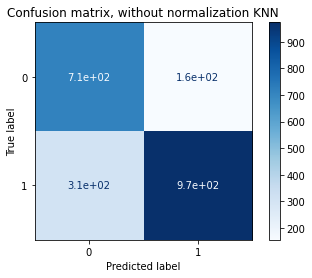

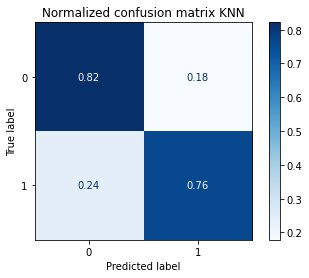

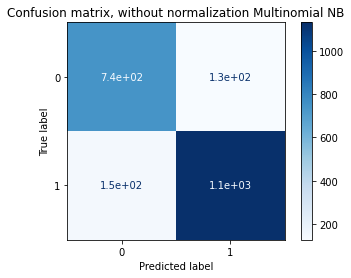

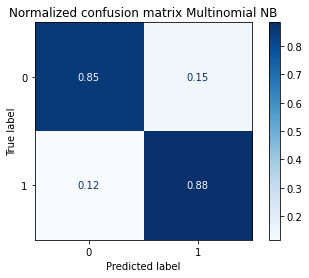

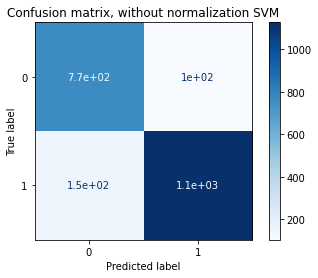

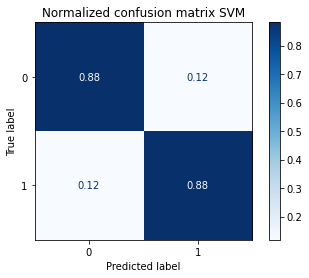

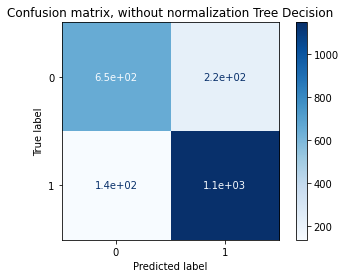

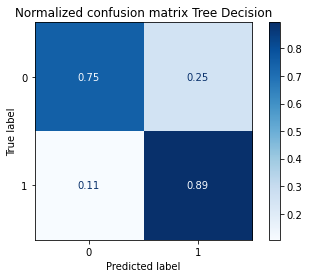

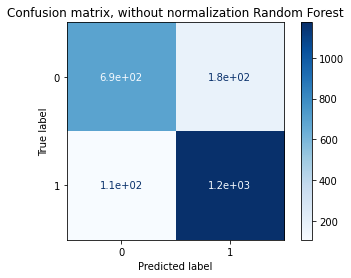

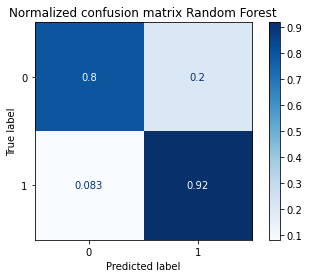

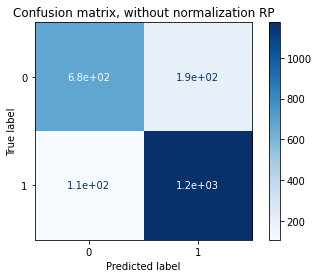

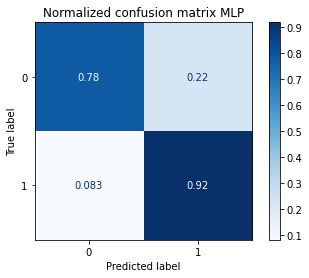

In [0]:
#desenhando a matriz de confusao
#duas matrizes 
#1) nao normalizada
#2) normalizada
titles_options = [("Confusion matrix, without normalization KNN", None),
                  ("Normalized confusion matrix KNN", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf2, testing_data, y_test,
                                 display_labels=df.label[1],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

print("\n")

titles_options = [("Confusion matrix, without normalization Multinomial NB", None),
                  ("Normalized confusion matrix Multinomial NB", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf3, testing_data, y_test,
                                 display_labels=df.label[1],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

print("\n")

titles_options = [("Confusion matrix, without normalization SVM", None),
                  ("Normalized confusion matrix SVM", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf4, testing_data, y_test,
                                 display_labels=df.label[1],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

print("\n")

titles_options = [("Confusion matrix, without normalization Tree Decision", None),
                  ("Normalized confusion matrix Tree Decision", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf5, testing_data, y_test,
                                 display_labels=df.label[1],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

print("\n")

titles_options = [("Confusion matrix, without normalization Random Forest", None),
                  ("Normalized confusion matrix Random Forest", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf6, testing_data, y_test,
                                 display_labels=df.label[1],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

print("\n")

titles_options = [("Confusion matrix, without normalization RP", None),
                  ("Normalized confusion matrix MLP", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf7, testing_data, y_test,
                                 display_labels=df.label[1],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

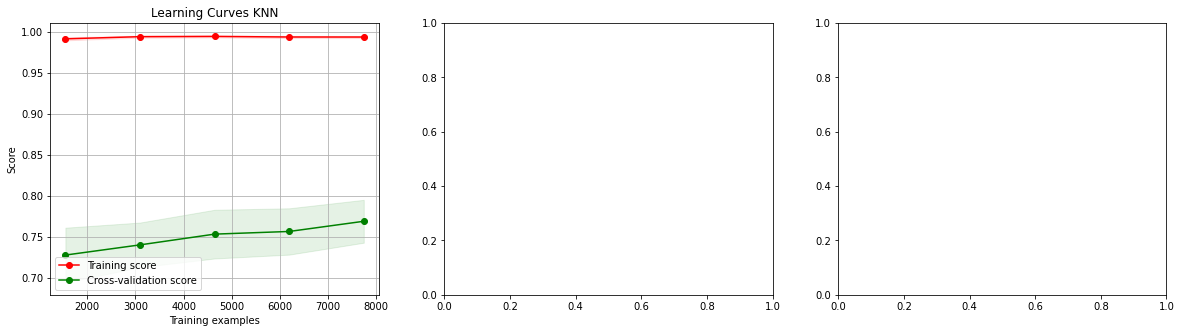

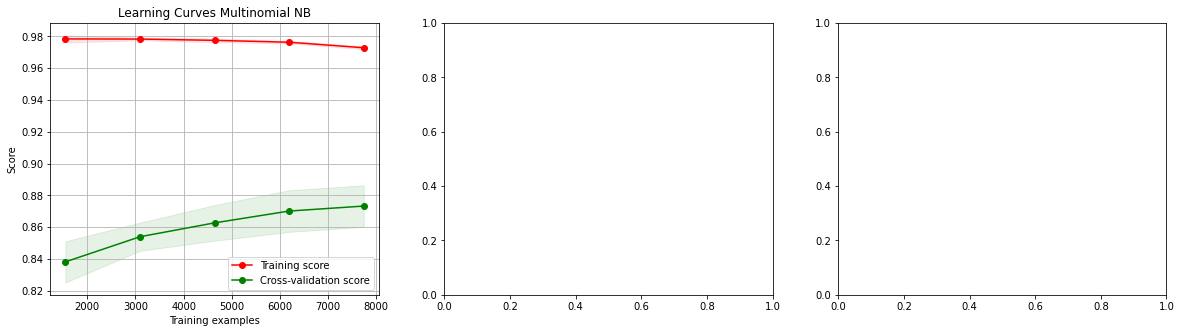

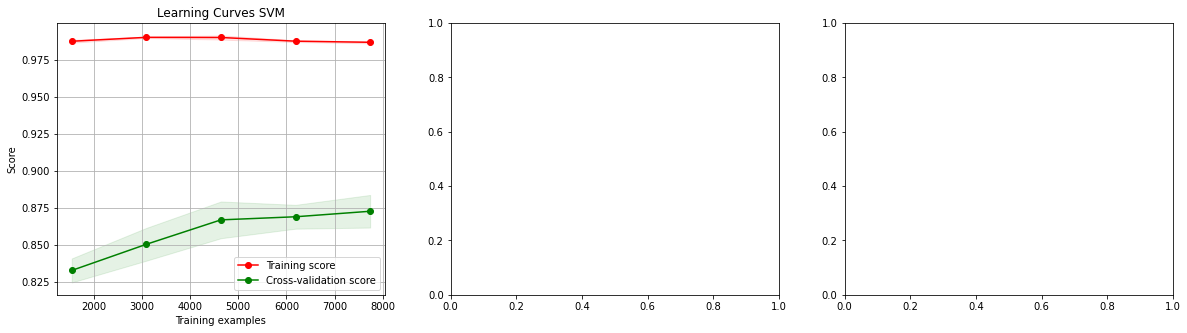

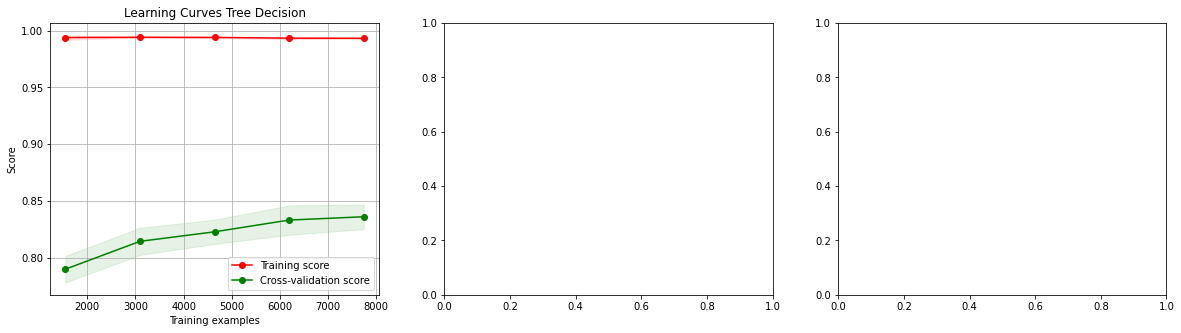

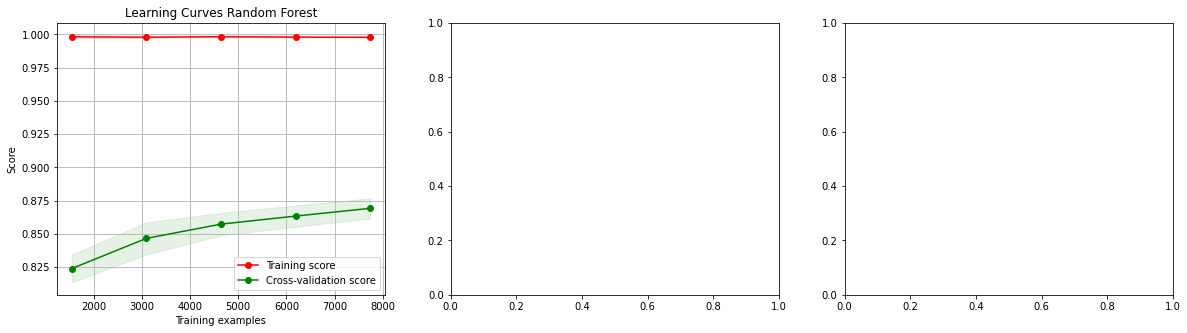

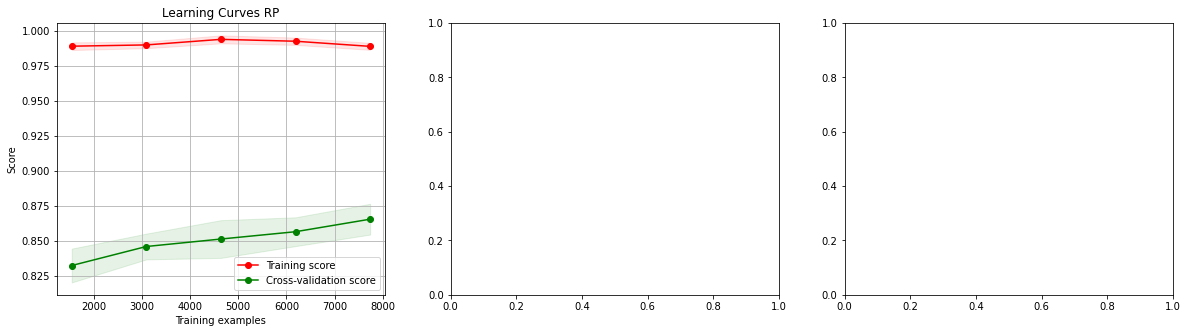

In [0]:
#plotando o grafico com a curva de aprendizado
title = "Learning Curves KNN"
plot_learning_curve(clf2, title, training_data, y_train, cv=10)

plt.show()

print("\n")

title = "Learning Curves Multinomial NB"
plot_learning_curve(clf3, title, training_data, y_train, cv=10)

plt.show()

print("\n")

title = "Learning Curves SVM"
plot_learning_curve(clf4, title, training_data, y_train, cv=10)

plt.show()

print("\n")

title = "Learning Curves Tree Decision"
plot_learning_curve(clf5, title, training_data, y_train, cv=10)

plt.show()

print("\n")

title = "Learning Curves Random Forest"
plot_learning_curve(clf6, title, training_data, y_train, cv=10)

plt.show()

print("\n")

title = "Learning Curves RP"
plot_learning_curve(clf7, title, training_data, y_train, cv=10)
plt.show()